<a href="https://colab.research.google.com/github/Sheriii11/555/blob/main/Image_Classification_using_Keras_VGG16_Fine_Tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'intel-image-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F111880%2F269359%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240316%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240316T173929Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1271b7902fa5c2c092f3edb9f842bff643d3e1f0cc0138821ba5301bf7e9645a85711b40372c0db6e8efc04c4be8504b50a71a705abc315f20884ef058b17cdc008e94b7be0f0d0063109320f427b8c070ab705c0440a14bfda1c62f2bc2a84f1473f5a590ae113078cc61066bd1d8d036f76179b68f5c113a1703f9e2660b31ee5bab3547f56552a8f7b70077196999871fbf3fc2bb58787e8b7829b114bab949a1f939d4a077186bb38d413f40dad7f33a8ed9f2fcdff80daffa4fb50936e4fe5721ebe3987535c4b709df7d9ddd73e3414b7563b858cefde054ad418ecd0c0534f0f7366d137ff77e0e4b1116e54bf038e95f1fade3d9a5cbf53fb42ea55f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 363152213 bytes downloaded
Downloaded and uncompressed: intel-image-classification
Data source import complete.


### **Import all the required packages**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers
import matplotlib.image as mpimg
import math
import os
import warnings
warnings.filterwarnings('ignore')

### **Setting directory paths and initializing parameters**

In [ ]:
BASE_DIR = '../input/intel-image-classification'
TRAIN_DIR = os.path.join(BASE_DIR, 'seg_train/seg_train')
TEST_DIR = os.path.join(BASE_DIR, 'seg_test/seg_test')
BATCH_SIZE = 32
EPOCHS = 20

#ImageDataGenerator for training data
TRAIN_DATAGEN = ImageDataGenerator(
                rescale = 1.0/255,
                validation_split = 0.2
                )

#ImageDataGenerator for testing data
TEST_DATAGEN = ImageDataGenerator(
                rescale = 1.0/255
                )

### **Displaying Images of each class**

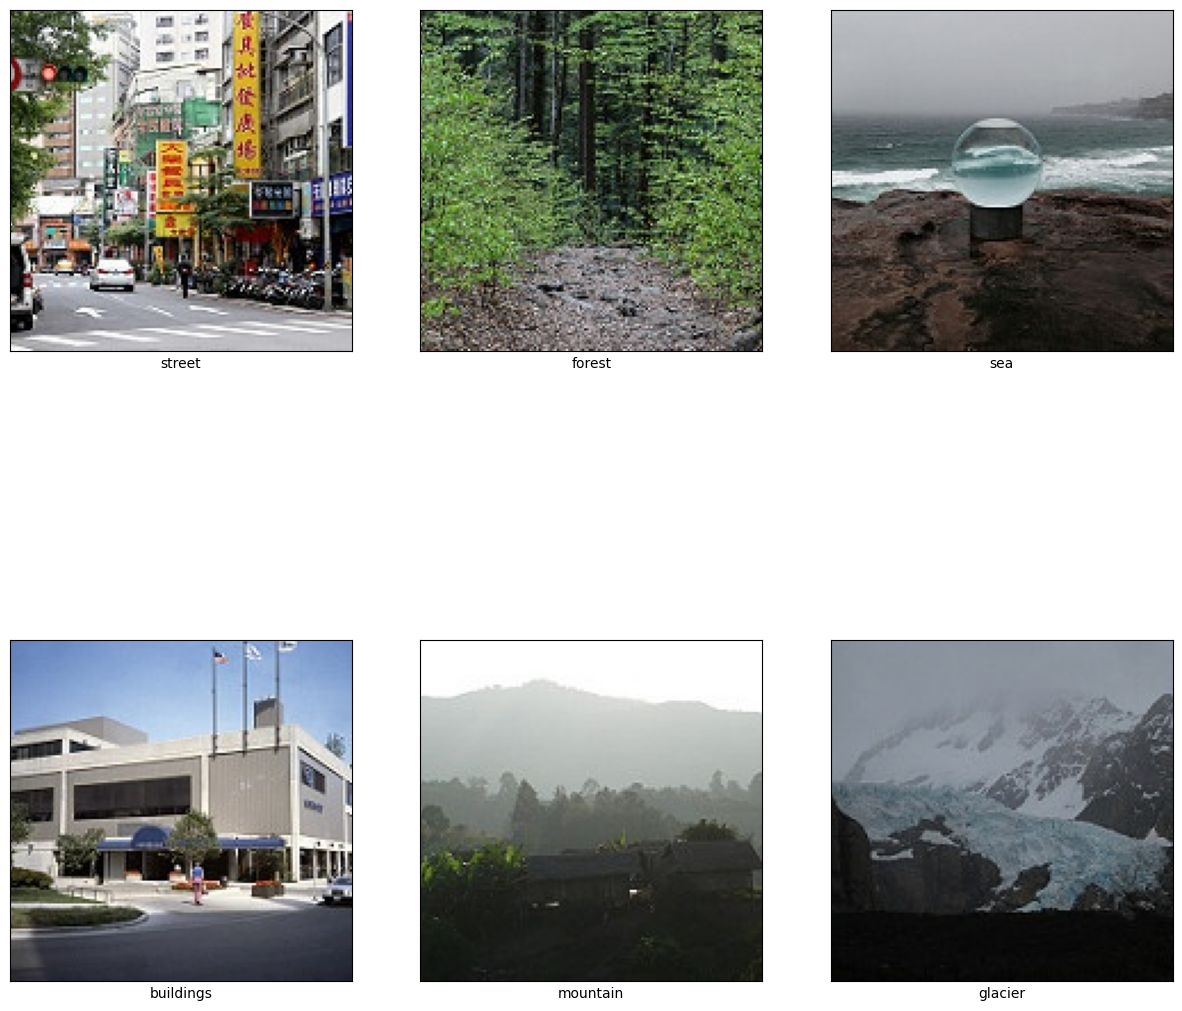

In [ ]:
j=0
fig=plt.figure(figsize=(15, 15))
for i in os.listdir(TRAIN_DIR):
        img = mpimg.imread(TRAIN_DIR+"/"+i+"/"+os.listdir(TRAIN_DIR+"/"+i)[0])
        fig.add_subplot(2,3,j+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(i)
        j += 1
plt.show()

### **Image distribution of each class in training and test set**

In [ ]:
print("TRAINING DATA:")
for i in os.listdir(TRAIN_DIR):
    files = os.listdir(TRAIN_DIR+"/"+i)
    print(f'{i} : {len(files)} files')

print("\n\nTEST DATA:")
for i in os.listdir(TEST_DIR):
    files = os.listdir(TEST_DIR+"/"+i)
    print(f'{i} : {len(files)} files')

TRAINING DATA:
street : 2382 files
forest : 2271 files
sea : 2274 files
buildings : 2191 files
mountain : 2512 files
glacier : 2404 files


TEST DATA:
street : 501 files
forest : 474 files
sea : 510 files
buildings : 437 files
mountain : 525 files
glacier : 553 files


# **Pre trained VGG16 Implementation**

### **Preparing Data**

In [ ]:
train_generator = TRAIN_DATAGEN.flow_from_directory(
                    TRAIN_DIR,
                    target_size = (150,150),
                    batch_size = BATCH_SIZE,
                    class_mode = 'categorical',
                    subset='training'
                  )

validation_generator = TRAIN_DATAGEN.flow_from_directory(
                    TRAIN_DIR,
                    target_size = (150,150),
                    batch_size = BATCH_SIZE,
                    class_mode = 'categorical',
                    subset='validation'
                  )

test_generator = TEST_DATAGEN.flow_from_directory(
                    TEST_DIR,
                    target_size = (150,150),
                    batch_size = BATCH_SIZE,
                    class_mode = 'categorical'
                  )

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Load the VGG16 model's **convolutional base**.

parameter include_top=False lets us **drop the trained classifier** from VGG16 model.

### Loading VGG16 Model and freezing all its layer

In [ ]:
conv_base = VGG16(
                    weights = 'imagenet',
                    include_top = False,
                    input_shape = (150,150,3)
                 )

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
set_trainable = False
for layer in conv_base.layers:
    layer.trainable = False

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### Defining our model with it's own classifier on top of VGG16 convolutional base.

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=2e-5), metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 16813638 (64.14 MB)
Trainable params: 2098950 (8.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
history = model.fit_generator(
                                train_generator,
                                steps_per_epoch = train_generator.samples // BATCH_SIZE,
                                epochs = EPOCHS,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.samples // BATCH_SIZE,
                             )

Epoch 1/20
350/350 [==============================] - 3617s 10s/step - loss: 0.5877 - acc: 0.7834 - val_loss: 0.3848 - val_acc: 0.8517
Epoch 2/20
219/350 [=================>............] - ETA: 17:44 - loss: 0.4076 - acc: 0.8498

In [ ]:
def plot_acc_loss(history):

    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_acc)+1)

    plt.plot(epochs, train_acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='red')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, train_loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss', color='red')
    plt.title("Training and Validation loss")
    plt.legend()
    plt.show()
    print("Average Validation loss: ", np.mean(val_loss))
    print(f"Average Validation accuracy: {np.mean(val_acc)*100:.2f} %")

In [ ]:
plot_acc_loss(history)

### Testset Accuracy before fine-tuning

In [ ]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test Accuracy before fine tuning: {test_acc*100:.2f} %")

## **Fine Tuning**

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name=='block5_conv1':
        set_trainable = True
    if set_trainable == True:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
conv_base.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-5), metrics=['acc'])
history = model.fit_generator(
                                train_generator,
                                steps_per_epoch = train_generator.samples // BATCH_SIZE,
                                epochs = EPOCHS,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.samples // BATCH_SIZE,
                             )

In [ ]:
plot_acc_loss(history)

### Testset Accuracy after fine-tuning

In [ ]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test Accuracy after fine tuning: {test_acc*100:.2f} %")